In [ ]:
import torch
import pandas as pd 
import torchvision
from torchvision import datasets, transforms
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import math
from sklearn.model_selection import train_test_split

In [ ]:
#Change to training dataset path 
TRAIN_SET = ""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper functions

In [ ]:
def convert_data_to_tensor(np_data,device):
    return torch.tensor(np_data,dtype=torch.float32).to(device)

def create_data_loader(np_input, np_label, batch_size, shuffle=False):
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

    input = Variable(convert_data_to_tensor(np_input,device))
    label = Variable(convert_data_to_tensor(np_label,device))

    if torch.cuda.is_available():
        input = input.cuda()
        label = label.cuda()

    data_loader = DataLoader(dataset=TensorDataset(input,label),
                             batch_size=batch_size,
                             shuffle=shuffle)
    return data_loader


def scale_data(rss_df):
    if not('pandas' in str(type(rss_df))):
        print("ERROR: Please Input Data in pandas.DataFrame")
        return -1

    new_rss = rss_df.copy()
    new_rss[new_rss == 100] = -110
    new_rss[new_rss == -100] = -110
    new_rss = new_rss.fillna(0)
    new_rss /= 110
    new_rss += 1
    return new_rss.values

def scale_xy(lon_lat, mean, std):
    return (lon_lat - mean) / std

def rescale_xy(scale_lon_lat, mean, std):
    scale_lon_lat = np.array(scale_lon_lat)
    lon = np.transpose(np.array([scale_lon_lat[:, 0]]))
    # lon = output[0]
    lon_rescaled = lon * std[0] + mean[0]

    lat = np.transpose(np.array([scale_lon_lat[:, 1]]))
    # lat = output[1]
    lat_rescaled = lat * std[1] + mean[1]
    return np.array([lon_rescaled, lat_rescaled]).transpose().reshape(-1,2)


def save_result (df_pred, df_true, data_name, case_name, save_path):
    # % SAVE RESULT
    df_result = df_pred.copy()

    df_result.join(df_true)
    file_path = join(save_path, "pred_{}_{}.csv".format(data_name,case_name))
    df_result.to_csv(file_path,header=True)


    # % Evaluate the Result
    eval_euclidean_distance(
        df_pred = df_pred,
        df_truth = df_true,
        dataset_name = data_name,
        case_name = case_name,
        save_path = save_path,
        run_time=-1,
        file_name="Eval_Results.csv",
        saveFlag=True
    )

    # Plot - Result
    Plot2Dlocation(df_true.values, [[case_name, df_pred.values]], save_path, data_name, case_name,
                   connectDots=True, saveFlag=True)

    print("-- [complete] save pred_{}_{}.csv".format(data_name,case_name))
#end save_result

In [ ]:
def Plot2Dlocation(np_xy_truth, list_xy_preds,result_path, dataset_name, plot_name, connectDots=True,saveFlag=False):
    """
    Plot the 2D map with the ground truth and prediction results (list_xy_preds could hold 1 set of results or more)
    :param main_info (HouseKeeping):
    :param np_xy_truth (Numpy):
    :param list_xy_preds (List<String,2d_np>): e.g. list_xy_preds=[["Euclidean",df_pred.values]]
    :param dataset_name (String):
    :param plot_name (String):
    :param connectDots (Bool):
    :param saveFlag (Bool):
    :return:
    """
    plt.clf()   #clear the plot
    fig, ax = plt.subplots(figsize=(16, 10))
    #Figure Info
    plt.title('{}\n({})'.format(plot_name,dataset_name))
    #plt.title(dataset_name,y=1)
    #plt.suptitle(plot_name, y=1.1, fontsize=18)
    #plt.title(dataset_name, fontsize=10)
    plt.xlabel('latitute')
    plt.ylabel('longitude')

    #plot groundtruth
    plt.plot(np_xy_truth[:,0], np_xy_truth[:,1], GRAPH_COLOUR[0]+MARKER[0],label="Ground Truth")

    #connect the points
    for caseNum in range(len(list_xy_preds)):
        #plot pred point (scatter)
        #plt.plot(list_xy_preds[caseNum][1][:, 0], list_xy_preds[caseNum][1][:, 1], GRAPH_COLOUR[caseNum+1] + MARKER[caseNum+1],label=list_xy_preds[caseNum][0])
        plt.scatter(list_xy_preds[caseNum][1][:, 0], list_xy_preds[caseNum][1][:, 1],c=GRAPH_COLOUR[caseNum+1],s=5,label=list_xy_preds[caseNum][0])

        if (connectDots):
            x = np.array([np_xy_truth[:, 0], list_xy_preds[caseNum][1][:, 0]])
            y = np.array([np_xy_truth[:, 1], list_xy_preds[caseNum][1][:, 1]])
            plt.plot(x, y, GRAPH_COLOUR[caseNum + 1], alpha=0.2)

    plt.legend()
    if saveFlag:
        saveName = join(result_path,dataset_name+"_"+plot_name+".png")
        plt.savefig(saveName)
    # plt.show()


    #endFunction Plot2Dlocation

# Datasets

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/FYP/SCALE/17-Aug-data-collection.csv')
data = pd.read_csv(TRAIN_SET)
label = data[["latitude_3414","longitude_3414"]]
data = data.drop(columns=['latitude_3414','longitude_3414','type','timestamp'])
data = data.iloc[: , :-1]


print(data)

     Unnamed: 0   BEA1   BEA2  BEA3  BEA4   BEA5  BEA6   BEA7
0             0 -101.0 -103.0 -86.0 -77.0  -83.0 -90.0 -100.0
1             1  -70.0  -84.0 -83.0 -83.0  -95.0 -90.0  -94.0
2             2  -70.0  -76.0 -85.0 -88.0  -92.0 -93.0  -93.0
3             3  -73.0  -78.0 -76.0 -88.0  -95.0 -90.0  -94.0
4             4  -75.0  -72.0 -80.0 -83.0  -96.0 -92.0  -94.0
..          ...    ...    ...   ...   ...    ...   ...    ...
628         628  -63.0  -64.0 -84.0 -99.0  -92.0 -85.0  -85.0
629         629  -64.0  -66.0 -84.0 -87.0 -100.0 -83.0  -90.0
630         630  -62.0  -64.0 -84.0 -80.0  -91.0 -94.0  -94.0
631         631  -60.0  -66.0 -82.0 -92.0  -95.0 -88.0  -94.0
632         632  -58.0  -70.0 -84.0 -91.0 -100.0 -96.0  -97.0

[633 rows x 8 columns]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
#Normalize training input data
X_train = scale_data(X_train)

# #Normalize training label: 
mean = np.mean(y_train.values, axis=0)
std = np.std(y_train.values, axis=0)
label = scale_xy(y_train.values, mean, std)
# print(label)

print(X_train)
#convert df to tensor object
data = torch.tensor(X_train)

label_t = torch.tensor(label)

#flatten 
data_t = torch.flatten(data,1)

label_t = torch.flatten(label_t,1)
print("data shape: " + str(data_t.shape))
print("label shape: " + str(label_t.shape))
print(label_t)


train_data = [] 
for i in range(len(data_t)):
    train_data.append([data_t[i],label_t[i]])


[[1.05454545 0.25454545 0.32727273 ... 0.16363636 0.11818182 0.12727273]
 [1.94545455 0.43636364 0.36363636 ... 0.12727273 0.22727273 0.22727273]
 [2.03636364 0.23636364 0.19090909 ... 0.         0.16363636 1.        ]
 ...
 [3.45454545 0.14545455 0.23636364 ... 0.22727273 0.27272727 0.4       ]
 [4.95454545 0.25454545 0.17272727 ... 0.10909091 0.36363636 0.21818182]
 [1.92727273 0.34545455 0.3        ... 0.15454545 0.15454545 0.10909091]]
data shape: torch.Size([506, 8])
label shape: torch.Size([506, 2])
tensor([[ 0.9212,  1.0236],
        [ 0.4393,  2.0160],
        [ 1.0014,  0.8583],
        ...,
        [-0.6259,  0.5917],
        [ 0.9604,  0.1783],
        [ 0.5196,  1.8506]], dtype=torch.float64)


In [ ]:
# data_val = pd.read_csv('file:/root/bryan/NG/csv-files/rfe-test.csv')
# label_val=data_val[["lon_3414","lat_3414"]]
# data_val=data_val.drop(columns=['type','timestamp','latitude','longitude','lon_3414','lat_3414','floor_id'])


#Normalize test input data 
X_test = scale_data(X_test) 

#Normalize training label
mean_val = np.mean(y_test.values, axis=0)
std_val = np.std(y_test.values, axis=0)
label_val = scale_xy(y_test.values, mean_val, std_val)

#convert df to tensor object
data_val_t1 = torch.tensor(X_test)

label_val_t = torch.tensor(label_val)

#flatten 
data_val_t = torch.flatten(data_val_t1,1)

label_val_t = torch.flatten(label_val_t,1)
print("data shape: " + str(data_val_t.shape))
print("label shape: " + str(label_val_t.shape))

val_data = [] 
for i in range(len(data_val_t)):
    val_data.append([data_val_t[i],label_val_t[i]])

data shape: torch.Size([127, 8])
label shape: torch.Size([127, 2])


In [ ]:
#put both train and validation sets into loader 
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8)
testloader = torch.utils.data.DataLoader(val_data, batch_size=8)
print("Finish dataset part")
print(data_val_t.shape[1])

Finish dataset part
8


# MODEL 

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(data_val_t.shape[1],5)
        self.fc2 = nn.Linear(5,5)
        self.fc3 = nn.Linear(5,5)
        self.fc4 = nn.Linear(5,2)

        
        # self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x =(F.relu(self.fc1(x)))
        x =(F.relu(self.fc2(x)))
        x =(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x

    
  


In [ ]:
from torchvision import models
from torchsummary import summary
model = Classifier()
print(model)



Classifier(
  (fc1): Linear(in_features=8, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)


In [ ]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()



In [ ]:
LR = 0.001


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
model = Classifier()
model.apply(weight_reset)
model.to(device)
#optimizer = optim.Adam(model.parameters(), lr= LR, eps = 1e-9) 
optimizer = optim.Adam(model.parameters(), lr= LR) 

# optimizer = optim.SGD(model.parameters(), lr = 0.001, weight_decay=0.03, momentum=0.003)
# optimizer = optim.SGD(model.parameters(), lr = LR)
criterion = nn.MSELoss() #MSE
#criterion = torch.nn.L1Loss()

epochs = 100
train_losses, test_losses = [],[]
pred = []

for e in range(epochs):
    tot_train_loss = 0 
    for data, labels in trainloader:
        data, labels = data.to(device), labels.to(device)
        data = data.view(data.shape[0],-1)
        data = data.float()
        optimizer.zero_grad()
        output = model(data)
        #print(output)
        #output = ((output - torch.mean(output))/torch.max(output)-torch.min(output))
        loss = torch.sqrt(criterion(output,labels.float())) #RMSE 
        #loss = criterion(output,labels.float())
        tot_train_loss+=loss.item()  
        
        loss.backward()
        optimizer.step()
        


    else:
        #if e>=100 and e%5==0 :
            #torch.save(model.state_dict(), './outputs/dec_control/dec-epoch-{}.pth'.format(e))
        tot_test_loss = 0 
        with torch.no_grad():
            for data, labels in testloader:
                data, labels = data.to(device), labels.to(device)
                data = data.view(data.shape[0],-1)
                data=data.float()
                test_output = model(data)
                loss = torch.sqrt(criterion(test_output,labels.float()))
                #loss = criterion(test_output,labels.float())

                tot_test_loss+=loss.item()
                
        train_loss = tot_train_loss/len(trainloader.dataset)
        test_loss = tot_test_loss/len(trainloader.dataset)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        pred.append(test_output)

        print("Epoch:{}/{}..".format(e+1,epochs),
             "Training Loss:{:.3f}..".format(train_loss),
             "Test Loss:{:.3f}..".format(test_loss))


Computation device: cpu

Epoch:1/100.. Training Loss:0.128.. Test Loss:0.032..
Epoch:2/100.. Training Loss:0.127.. Test Loss:0.032..
Epoch:3/100.. Training Loss:0.126.. Test Loss:0.032..
Epoch:4/100.. Training Loss:0.126.. Test Loss:0.031..
Epoch:5/100.. Training Loss:0.126.. Test Loss:0.031..
Epoch:6/100.. Training Loss:0.126.. Test Loss:0.031..
Epoch:7/100.. Training Loss:0.125.. Test Loss:0.031..
Epoch:8/100.. Training Loss:0.124.. Test Loss:0.031..
Epoch:9/100.. Training Loss:0.122.. Test Loss:0.030..
Epoch:10/100.. Training Loss:0.119.. Test Loss:0.030..
Epoch:11/100.. Training Loss:0.114.. Test Loss:0.028..
Epoch:12/100.. Training Loss:0.109.. Test Loss:0.027..
Epoch:13/100.. Training Loss:0.105.. Test Loss:0.027..
Epoch:14/100.. Training Loss:0.101.. Test Loss:0.026..
Epoch:15/100.. Training Loss:0.099.. Test Loss:0.025..
Epoch:16/100.. Training Loss:0.097.. Test Loss:0.025..
Epoch:17/100.. Training Loss:0.096.. Test Loss:0.025..
Epoch:18/100.. Training Loss:0.095.. Test Loss:0.

<Figure size 1152x648 with 0 Axes>

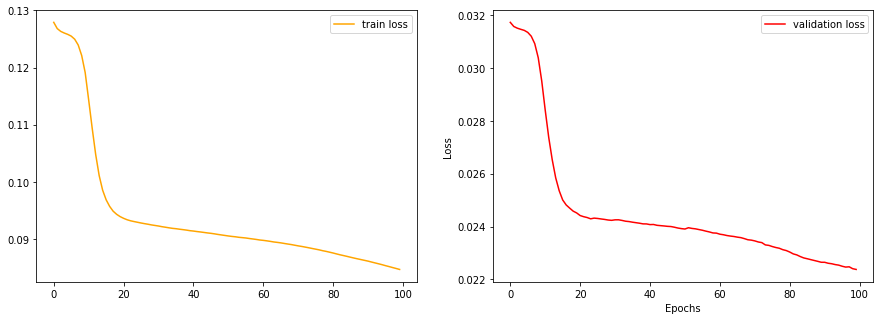

In [ ]:
import matplotlib.pyplot as plt


# loss plots
plt.figure(figsize=(16,9))
# fig, (ax1, ax2) = plt.subplots(1, 2)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(train_losses, color='orange', label='train loss',)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax1.legend()

# loss plots
ax2.plot(test_losses, color='red', label='validation loss')
ax2.legend()
# plt.show()

# Evaluation

In [ ]:
def evaluate(test_input, test_label, model, loss_fn, xy_mean, xy_std):
    model.eval()
    pred = model(convert_data_to_tensor((test_input), device))
    val_loss = loss_fn(
        convert_data_to_tensor(rescale_xy(pred.data.cpu().numpy(), xy_mean, xy_std), device),
        convert_data_to_tensor(test_label, device)).data
    return val_loss.item(), rescale_xy(pred.data.cpu().numpy(), xy_mean, xy_std)

# label_xy = scale_xy(y_test.values, mean_val, std_val)
validation_loss, validation_pred = evaluate(X_test,y_test.values, model, criterion, mean, std)
# validation_pred_xy = scale_xy(validation_pred, mean_val, std_val)

In [ ]:
labels = y_test.values
print(labels[0])
print(validation_pred[0])
dist_list = [] 
for i in range(len(validation_pred)):
    dist = np.linalg.norm(validation_pred[i]-labels[i])
    dist_list.append(dist)
    
print("Validation loss: " + str('{0:.2f}'.format(validation_loss)))
print("Max: " + str('{0:.10f}'.format(max(dist_list))) + " m")
print("Min: " + str('{0:.10f}'.format(min(dist_list))) + " m")
print("Average: " + str('{0:.10f}'.format(np.average(dist_list))) + " m")
# print(label_val_new_1)


[36482.16709 11119.44879]
[36477.715 11116.96 ]
Validation loss: 17.71
Max: 21.9183729595 m
Min: 0.4032273771 m
Average: 5.0456973438 m


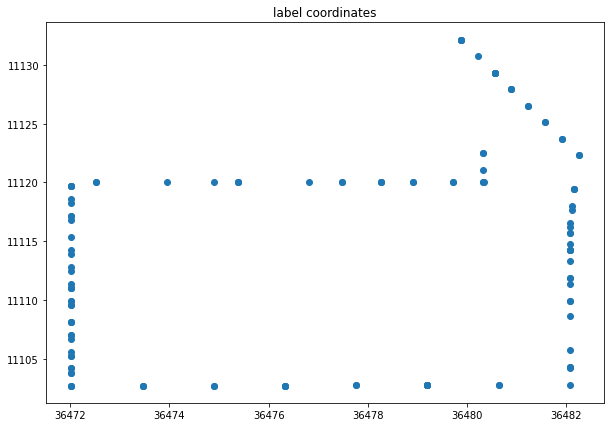

In [ ]:
GRAPH_COLOUR = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
MARKER = ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']
plt.figure(figsize=(10, 7))
x,y = labels.T
plt.scatter(x,y)
plt.title("label coordinates")
plt.show()

<Figure size 432x288 with 0 Axes>

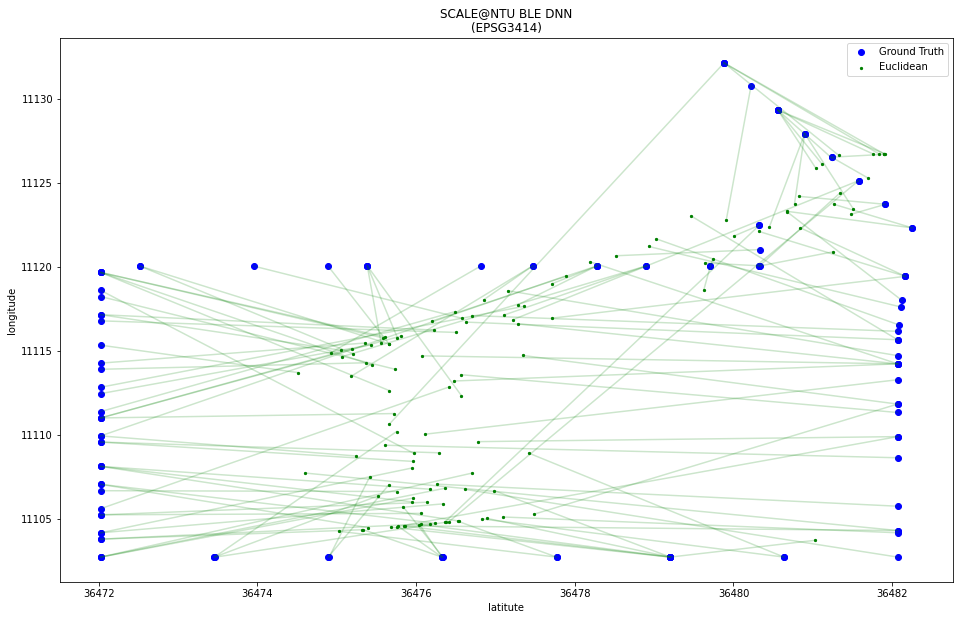

In [ ]:
Plot2Dlocation(labels, [["Euclidean",validation_pred]],"test","EPSG3414","SCALE@NTU BLE DNN")